# Simple Forward Simulation of Burgers Equation with Φ<sub>Flow</sub>

This chapter will give an introduction for how to run _forward_, i.e., regular simulations starting with a given initial state and approximating a later state numerically, with Φ<sub>Flow</sub>.

Burgers equations is a very simple, yet non-linear and non-trivial, model equation, and hence a very good starting point for experiments. It contains an advection and a diffusion term, and can lead to interesting shock formations due to a lack of additional constraints:
$
    \frac{\partial u}{\partial{t}} + u \nabla u =
    \nu \nabla\cdot \nabla u
$ 

Let's get some preliminaries out of the way: we'll import the Φ<sub>Flow</sub> library, and define our simulation domain with $n=128$ cells as discretization points for the 1D velocity $u$ in a periodic domain $\Omega$ for the interval $[-1,1]$. We'll use 32 time `steps` for a time interval of 1, giving us `dt=1/32`. Additionally, we'll use a viscosity of $\nu=0.01/\pi$.

We'll also define an initial state given by $-\text{sin}(\pi x$ in the numpy array `initial`, which we'll use to initialize the velocity $u$ in the simulation in the next cell.

**Note:** Below, the first command with a "!" prefix installs the [Φ<sub>Flow</sub> Python package from GitHub](https://github.com/tum-pbs/PhiFlow) via `pip` in your python environment. (You can skip or modify this command if necessary, depending on your system.)

In [1]:
#!pip install --upgrade --quiet phiflow
from phi.flow import *

# run with phiflow
n = 128
steps = 32
dt = 1./steps
nu = 0.01/np.pi

initial = np.asarray( [-np.sin(np.pi * x) * 1. for x in np.linspace(-1,1,n)] ) # 1D array
#initial = np.asarray( [ [-np.sin(np.pi * x) * 1.] for x in np.linspace(-1,1,n)] ) # with additional component channel
initial.shape

(128,)

Next we can define `domain` to contain $\Omega$, as outlined above periodically for $[-1,1]$, and initialize a 1D `velocity` from the `initial` array.

Just to illustrate, we'll also print some info about the velocity object: it's `phiflow.math` tensor with a size of 128. Note that the actual grid content is contained in the `values` of the grid. Below we're printing the first five values via the conversion to a numpy array with `numpy()`.

In [2]:
domain = Domain(x=n, boundaries=PERIODIC, bounds=Box[-1:1])
#velocity = domain.staggered_grid(initial)
#velocity = domain.grid(initial)
velocity = domain.grid(Noise(vector=1))

print("Velocity tensor shape: "   + format( velocity.shape )) # == velocity.values.shape
print("Velocity tensor type: "    + format( type(velocity.values) ))
print("Velocity tensor content: " + format( velocity.values.numpy()[0:5] ))

Velocity tensor shape: (x=128, vector=1)
Velocity tensor type: <class 'phi.math._tensors.NativeTensor'>
Velocity tensor content: [[0.5569957 ]
 [0.5911083 ]
 [0.62823397]
 [0.68026114]
 [0.72364265]]


/Users/thuerey/Dropbox/mbaDevelSelected/phiflow-v2/phi/math/backend/_scipy_backend.py:255: RuntimeWarning: overflow encountered in exp
  return np.exp(x)


## Running the simulation

Now we're ready to run the simulation itself. To compute the diffusion and advection components of our model equation we can simply call the existing `diffusion` and `semi_lagrangian` operators in phiflow:

In [3]:
velocities = [velocity]
age = 0.
for i in range(steps):
    v1 = field.diffuse(velocities[-1], nu, dt)
    v2 = advect.semi_lagrangian(v1, v1, dt)
    age += dt
    velocities.append(v2)

print("New velocity content at t={}: {}".format( age, velocities[-1].values.numpy()[0:5] ))

New velocity content at t=1.0: [[0.15099575]
 [0.16271012]
 [0.17444186]
 [0.18618482]
 [0.19793215]]


Here we're actually collecting all time steps in the `vels` list. This is not necessary in general (and could consume lots of memory for long-running sims), but useful here to show the evolution of the velocity states.

The print statements print a few of the velocities and already shows that something is happening in our simulation, but it's difficult to get an intuition for the behavior of the PDE just from these numbers. Hence, let's visualize the states over time to show what is happening.

## Visualization

We can visualize them in graph: the following code shows the initial state in blue, and then times $10/32, 20/32, 1$ in green, cyan and purple. 

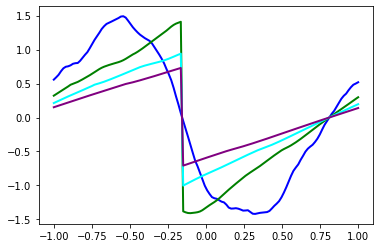

In [4]:
# we only need "velocity.data" from each phiflow state
vels = [x.values.numpy() for x in velocities]

# print(vels[0][0,:,0].shape)
# print(vels[0].shape[1])

import matplotlib.pyplot as plt

fig = plt.figure().gca()
fig.plot(np.linspace(-1,1,len(vels[ 0].flatten())), vels[ 0].flatten(), lw=2, color='blue')
fig.plot(np.linspace(-1,1,len(vels[10].flatten())), vels[10].flatten(), lw=2, color='green')
fig.plot(np.linspace(-1,1,len(vels[20].flatten())), vels[20].flatten(), lw=2, color='cyan')
fig.plot(np.linspace(-1,1,len(vels[32].flatten())), vels[32].flatten(), lw=2, color='purple')


This nicely shows the shock developing in the center of our domain, which forms from the collision of the two initial bumps which are located left and right of the center.

As these lines can overlap quite a bit we'll also use a different visualization in the following chapters that shows the evolution over the course of all time steps in a 2D image. Our 1D domain will be shown along the Y-axis, and each point along X will represent one time step.

The code below converts our collection of velocity states into a 2D array, repeating individual time steps 8 times to make the image a bit wider. This purely optional, of course, but makes it easier to see what's happening in our Burgers simulation.

Vels array shape: (128, 33, 1)


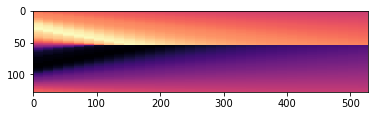

In [5]:
def show_state(a):
    # we only have 33 time steps, blow up by a factor of 2^4 to make it easier to see
    # (could also be done with more evaluations of network)
    for i in range(4):
        a = np.concatenate( [a,a] , axis=2)

    a = np.reshape( a, [a.shape[0],a.shape[1]*a.shape[2]] )
    #print("resulting image size" +format(a.shape))
    plt.imshow(a, origin='upper', cmap='magma')
    
vels_img = np.asarray( np.concatenate(vels, axis=-1), dtype=np.float32 )
vels_img = np.reshape(vels_img, list(vels_img.shape)+[1] ) ; print("Vels array shape: "+format(vels_img.shape))

# save for comparison with reconstructions later on
np.savez_compressed("./temp/burgers-groundtruth-solution.npz", np.reshape(vels_img,[n,steps+1])) # remove batch & channel dimension

show_state(vels_img)

## Next steps

Some things to try based on this simulation setup:

- Feel free to experiment - the setup above is very simple, you can change the simulation parameters, or the initialization. E.g., you can use a noise field via `Noise(vector=1)` to get more chaotic results.
- A bit more complicated: extend the simulation to 2D (or higher). This will require changes throughout, but all operators above support higher dimensions. Before trying this, you probably will want to check out the next example, which covers a 2D Navier-Stokes case.